# 1 - Open Exploration

## 1.1. Exploratory Analysis

In this section, we apply scenario discovery to identify the uncertainty space. Our aim is to maximize the minimum water level in the system. 
We will use Problem formulation 2. We have previously added the Minimum Water Level as an outcome in [Problem Formulation](problem_formulation.py) by adding the function min_over_pf2.


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns

from ema_workbench import MultiprocessingEvaluator
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench import load_results



In [143]:
# Importing EMA workbench
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

### Business as Usual Analysis: Global sensitivity using SOBOL- Celia

Check what are the most uncertain parameters in the status quo, especial focus on the Minimum water level outcome. 
We will focus afterwards on these parameters

### Random policies - Celia
First, we explore the lever space by sampling random lever combinations (policies)

We are agoing to address the worst possible combinations, so our client can avoid them. We do this to have a first picture.

We have to keep in mind that some combinations may be absurd, (RfR in 2020 On and RfR in 2025 off, nonsense)

Output: Worst case scenarios that make sense

In [144]:
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time


dike_model, planning_steps = get_model_for_problem_formulation(2)

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [145]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Minimum Water Level', variable_name=('A.1_Water Level', 'A.2_Water Level', 'A.3_Water Level', 'A.4_Water Level', 'A.5_Water Level'), function=<function min_over_pf2 at 0x125a3fa60>)
ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x125a3f880>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x125a3f880>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x125a3f880>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x125a3f880>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_

In [146]:
# ---Run  experiments with random combination of levers and plot results---


ema_logging.log_to_stderr(ema_logging.INFO)

scenarios = 1000
policies = 10

with MultiprocessingEvaluator(dike_model) as evaluator:
    random_results = evaluator.perform_experiments(scenarios, policies)

random_experiments, random_outcomes = random_results


[MainProcess/INFO] pool started with 14 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [01:50<00:00, 90.28it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [147]:
random_experiments.dtypes

A.0_ID flood wave shape       int64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                       int64
0_RfR 1                       int64
0_RfR 2                       int64
1_RfR 0                       int64
1_RfR 1                       int64
1_RfR 2                       int64
2_RfR 0                       int64
2_RfR 1                       int64
2_RfR 2                     

In [148]:
#RfR should be 0 or 1, so we can convert it to boolean
for col in random_experiments.columns:
    if 'RfR' in col:
        random_experiments[col] = random_experiments[col].astype(bool)

# Dike heightening should float
for col in random_experiments.columns:
    if 'DikeIncrease' in col:
        random_experiments[col] = random_experiments[col].astype(float)

random_experiments.dtypes

A.0_ID flood wave shape       int64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                        bool
0_RfR 1                        bool
0_RfR 2                        bool
1_RfR 0                        bool
1_RfR 1                        bool
1_RfR 2                        bool
2_RfR 0                        bool
2_RfR 1                        bool
2_RfR 2                     

In [149]:
random_experiments_df = pd.DataFrame(random_experiments)

random_cleaned_experiments = random_experiments_df.drop(labels=[l.name for l in dike_model.levers], axis=1)
random_experiments_df

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,44,309.170690,10.0,0.083585,68.204080,1.5,0.625982,168.115644,1.5,0.361111,...,8.0,8.0,0.0,8.0,4.0,4.0,3,5460,5450,dikesnet
1,107,95.720161,1.0,0.606893,124.522400,10.0,0.111057,145.273139,1.5,0.082365,...,8.0,8.0,0.0,8.0,4.0,4.0,3,5461,5450,dikesnet
2,99,227.318268,1.5,0.001981,56.684208,1.0,0.870330,231.990464,1.0,0.474610,...,8.0,8.0,0.0,8.0,4.0,4.0,3,5462,5450,dikesnet
3,116,138.182486,1.5,0.311619,82.759252,1.0,0.319999,346.018096,1.5,0.561703,...,8.0,8.0,0.0,8.0,4.0,4.0,3,5463,5450,dikesnet
4,45,201.498100,10.0,0.423930,96.910373,1.5,0.785241,275.123727,1.0,0.275367,...,8.0,8.0,0.0,8.0,4.0,4.0,3,5464,5450,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,72,256.161476,1.0,0.667054,69.626108,10.0,0.285422,252.707832,1.0,0.998281,...,0.0,10.0,4.0,7.0,2.0,4.0,2,6455,5459,dikesnet
9996,122,65.898629,10.0,0.553659,338.129825,1.5,0.720682,81.351980,1.0,0.086437,...,0.0,10.0,4.0,7.0,2.0,4.0,2,6456,5459,dikesnet
9997,48,68.770772,10.0,0.162974,327.344486,1.5,0.995124,89.116334,10.0,0.873484,...,0.0,10.0,4.0,7.0,2.0,4.0,2,6457,5459,dikesnet
9998,120,47.162122,1.0,0.970927,40.572461,1.0,0.974785,147.930174,1.0,0.019924,...,0.0,10.0,4.0,7.0,2.0,4.0,2,6458,5459,dikesnet


[MainProcess/INFO] no time dimension found in results


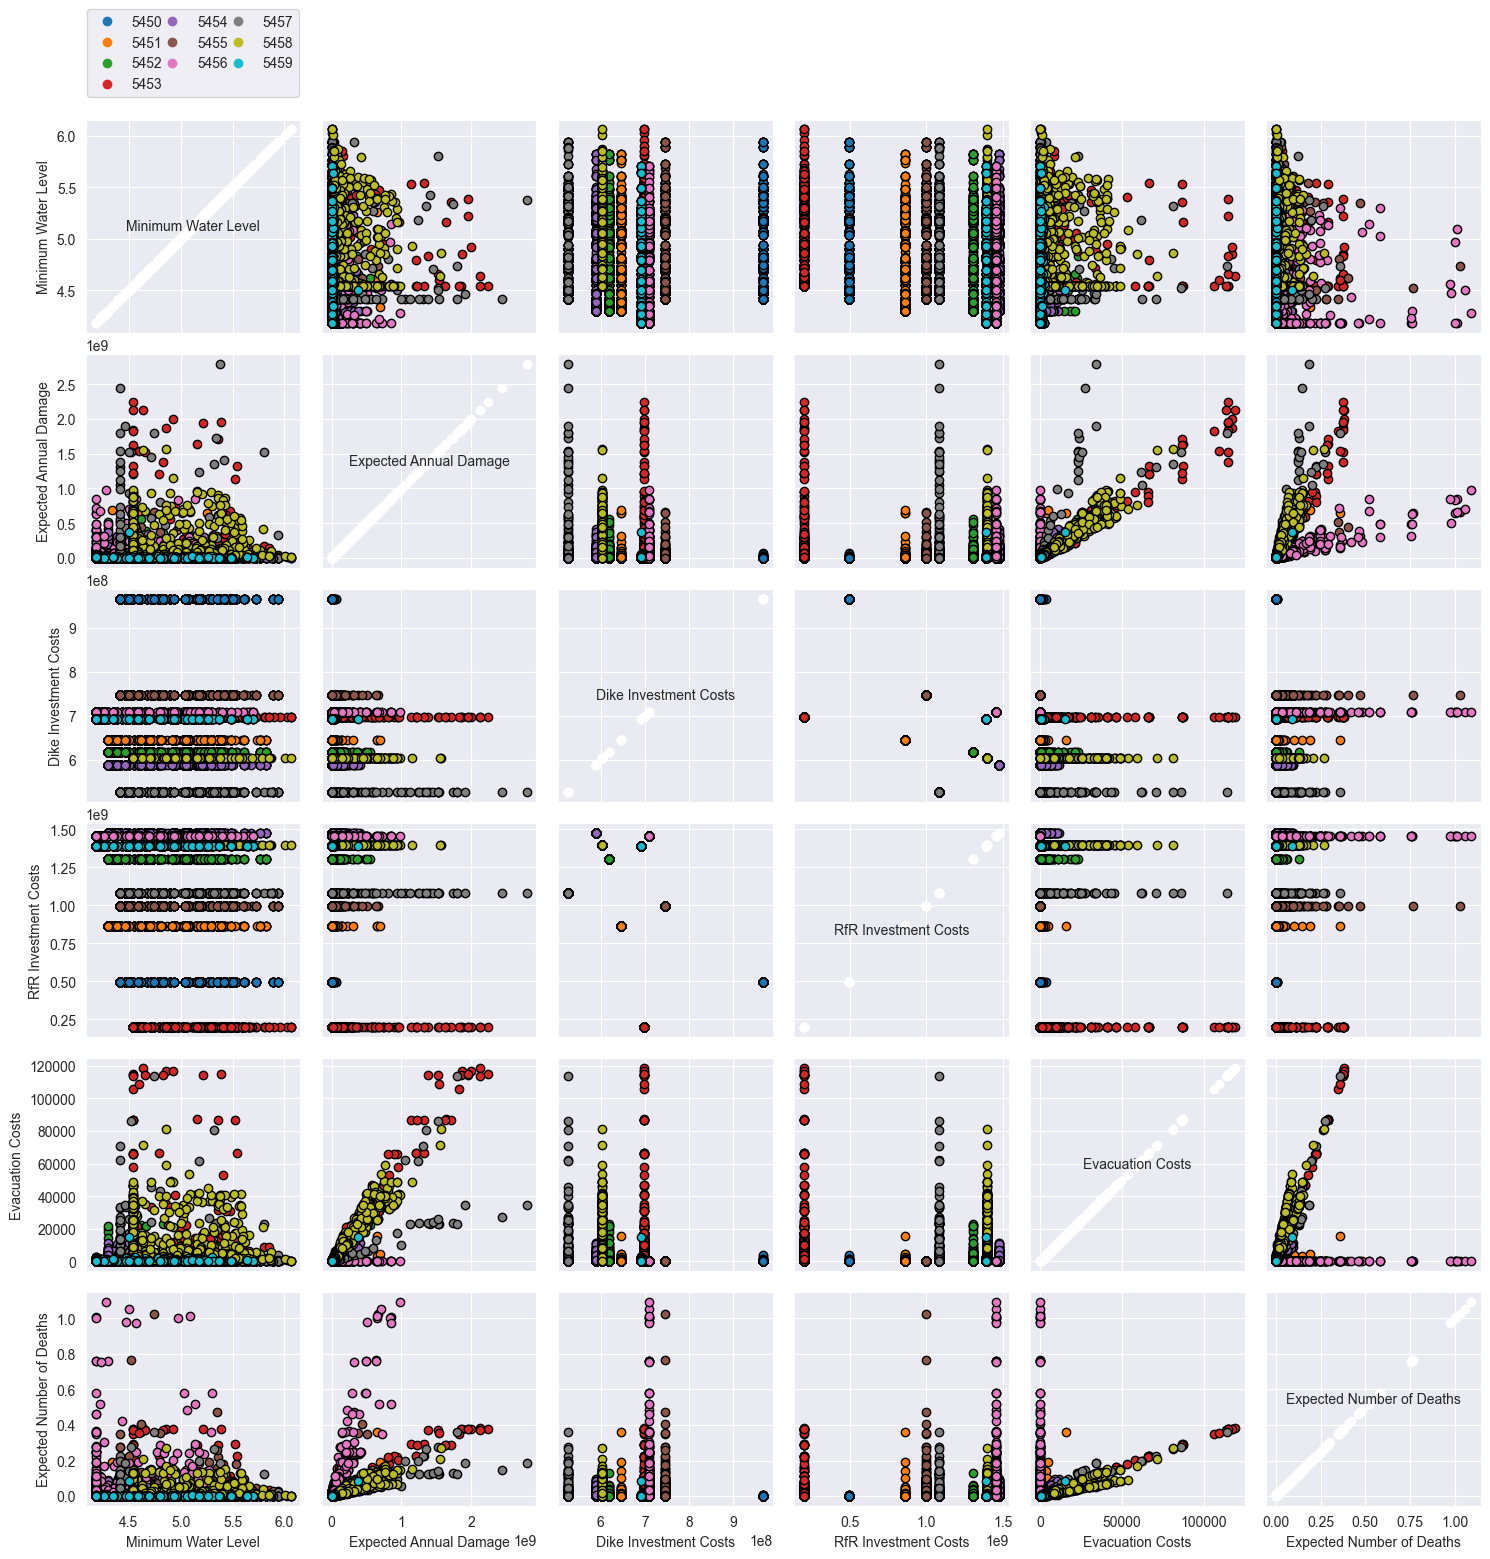

In [150]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(random_experiments, random_outcomes,group_by='policy', legend=True, figsize=(10, 10))
fig.set_size_inches(18, 18)
plt.show()

In [151]:
from ema_workbench import save_results
save_results(random_results, 'results_ 100 scenarios_10 policies.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/amaryllisbrosens/PycharmProjects/MBDM-Group-1/results_ 100 scenarios_10 policies.tar.gz


### Selected policies - Amaryllis
Now, we are going to test several policies that were discussed during the first debate. Analyzing these policies will provide us a first big picture of the system.

The policies that will be studied are: 

0. Business as usual (BAU)

From [problem_formulation](problem_formulation.py) 's default:
1. policy 1 is about extra protection in upper boundary
2. policy 2 is about extra protection in lower boundary
3. policy 3 is extra protection in random locations

From the first debate: 

4. Room for the River in Doesburg (A1) and Zuthpen (A3)
5. Room for the River in  Doesburg (A1) and Zuthpen (A3) + dike heightening of 5 meters in Cortenoever (A2) and Gorssel (A4) in time decision 0


#TODO add policies with different time decision, right now everthing is at 0.

Outcome of this section: which are the best policies only focusing on water level

In [152]:
#TODO add policies with different time decision, right now everthing is at 0.


In [153]:

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_open_exp = [
        Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),
    Policy(
        "RfR and DH in A1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "RfR and DH in A5",
        **dict(
            get_do_nothing_dict(),
            **{"4_RfR 0": 1, "4_RfR 1": 1, "4_RfR 2": 1, "A.5_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "RfR in A1, A2, A3 and DH in A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 1": 1, "3_RfR 2": 1, "A.3_DikeIncrease 0": 5}
        )
    ),
    #RFR in Doesburg and Zuthpen as they talked about in the debate
    Policy(
        "RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 1, "3_RfR 1": 1, '3_RfR 2': 1,}
        )
    ),

#RFR in Doesburg and Zuthpen and dike heightening in Cortenoever and Gorssel
     Policy(
        "RfR in A1 and A3 and DH in A2 and A4",
        **dict(
            get_do_nothing_dict(),
            **{# RfR for A1
            "1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
            # RfR for A3
            "3_RfR 0": 1, "3_RfR 1": 1, "3_RfR 2": 1,
            # DikeIncrease for A2
            "2_DikeIncrease 0": 5, "2_DikeIncrease 1": 0, "2_DikeIncrease 2": 0,
            # DikeIncrease for A4
            "4_DikeIncrease 0": 5, "4_DikeIncrease 1": 0, "4_DikeIncrease 2": 0}))
]

In [154]:
# NEW POLICIES WITH TIME
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_open_exp = [
        Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),
    Policy(
        "RfR and DH in A1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "RfR and DH in A5",
        **dict(
            get_do_nothing_dict(),
            **{"4_RfR 0": 1, "4_RfR 1": 1, "4_RfR 2": 1, "A.5_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "RfR in A1, A2, A3 and DH in A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 1": 1, "3_RfR 2": 1, "A.3_DikeIncrease 0": 5}
        )
    ),
    #RFR in Doesburg and Zuthpen as they talked about in the debate
    Policy(
        "RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 1, "3_RfR 1": 1, '3_RfR 2': 1,}
        )
    ),

        #RFR in Zuthpen
    Policy(
        "RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 0, "1_RfR 1": 0, "1_RfR 2": 0,
               "3_RfR 0": 1, "3_RfR 1": 1, '3_RfR 2': 1,}
        )
    ),

        #RFR in Doesburg
    Policy(
        "RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 0, "3_RfR 1": 0, '3_RfR 2': 0,}
        )
    ),

#RFR in Doesburg and Zuthpen and dike heightening in Cortenoever and Gorssel
     Policy(
        "RfR in A1 and A3 and DH in A2 and A4",
        **dict(
            get_do_nothing_dict(),
            **{# RfR for A1
            "1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
            # RfR for A3
            "3_RfR 0": 1, "3_RfR 1": 1, "3_RfR 2": 1,
            # DikeIncrease for A2
            "2_DikeIncrease 0": 5, "2_DikeIncrease 1": 0, "2_DikeIncrease 2": 0,
            # DikeIncrease for A4
            "4_DikeIncrease 0": 5, "4_DikeIncrease 1": 0, "4_DikeIncrease 2": 0})),

    #RFR in Doesburg and Zuthpen as they talked about in the debate
    Policy(
        "TIME RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 0, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 0, "3_RfR 1": 1, '3_RfR 2': 1,}
        )
    ),

#RFR in Doesburg and Zuthpen and dike heightening in Cortenoever and Gorssel
     Policy(
        "TIME RfR in A1 and A3 and DH in A2 and A4",
        **dict(
            get_do_nothing_dict(),
            **{# RfR for A1
            "1_RfR 0": 0, "1_RfR 1": 1, "1_RfR 2": 1,
            # RfR for A3
            "3_RfR 0": 0, "3_RfR 1": 1, "3_RfR 2": 1,
            # DikeIncrease for A2
            "2_DikeIncrease 0": 0, "2_DikeIncrease 1": 5, "2_DikeIncrease 2": 0,
            # DikeIncrease for A4
            "4_DikeIncrease 0": 5, "4_DikeIncrease 1": 0, "4_DikeIncrease 2": 0}))

]

In [155]:

# pass the policies list to EMA workbench experiment runs
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_open_exp)



[MainProcess/INFO] pool started with 14 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [01:56<00:00, 86.17it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [156]:
experiments, outcomes = results

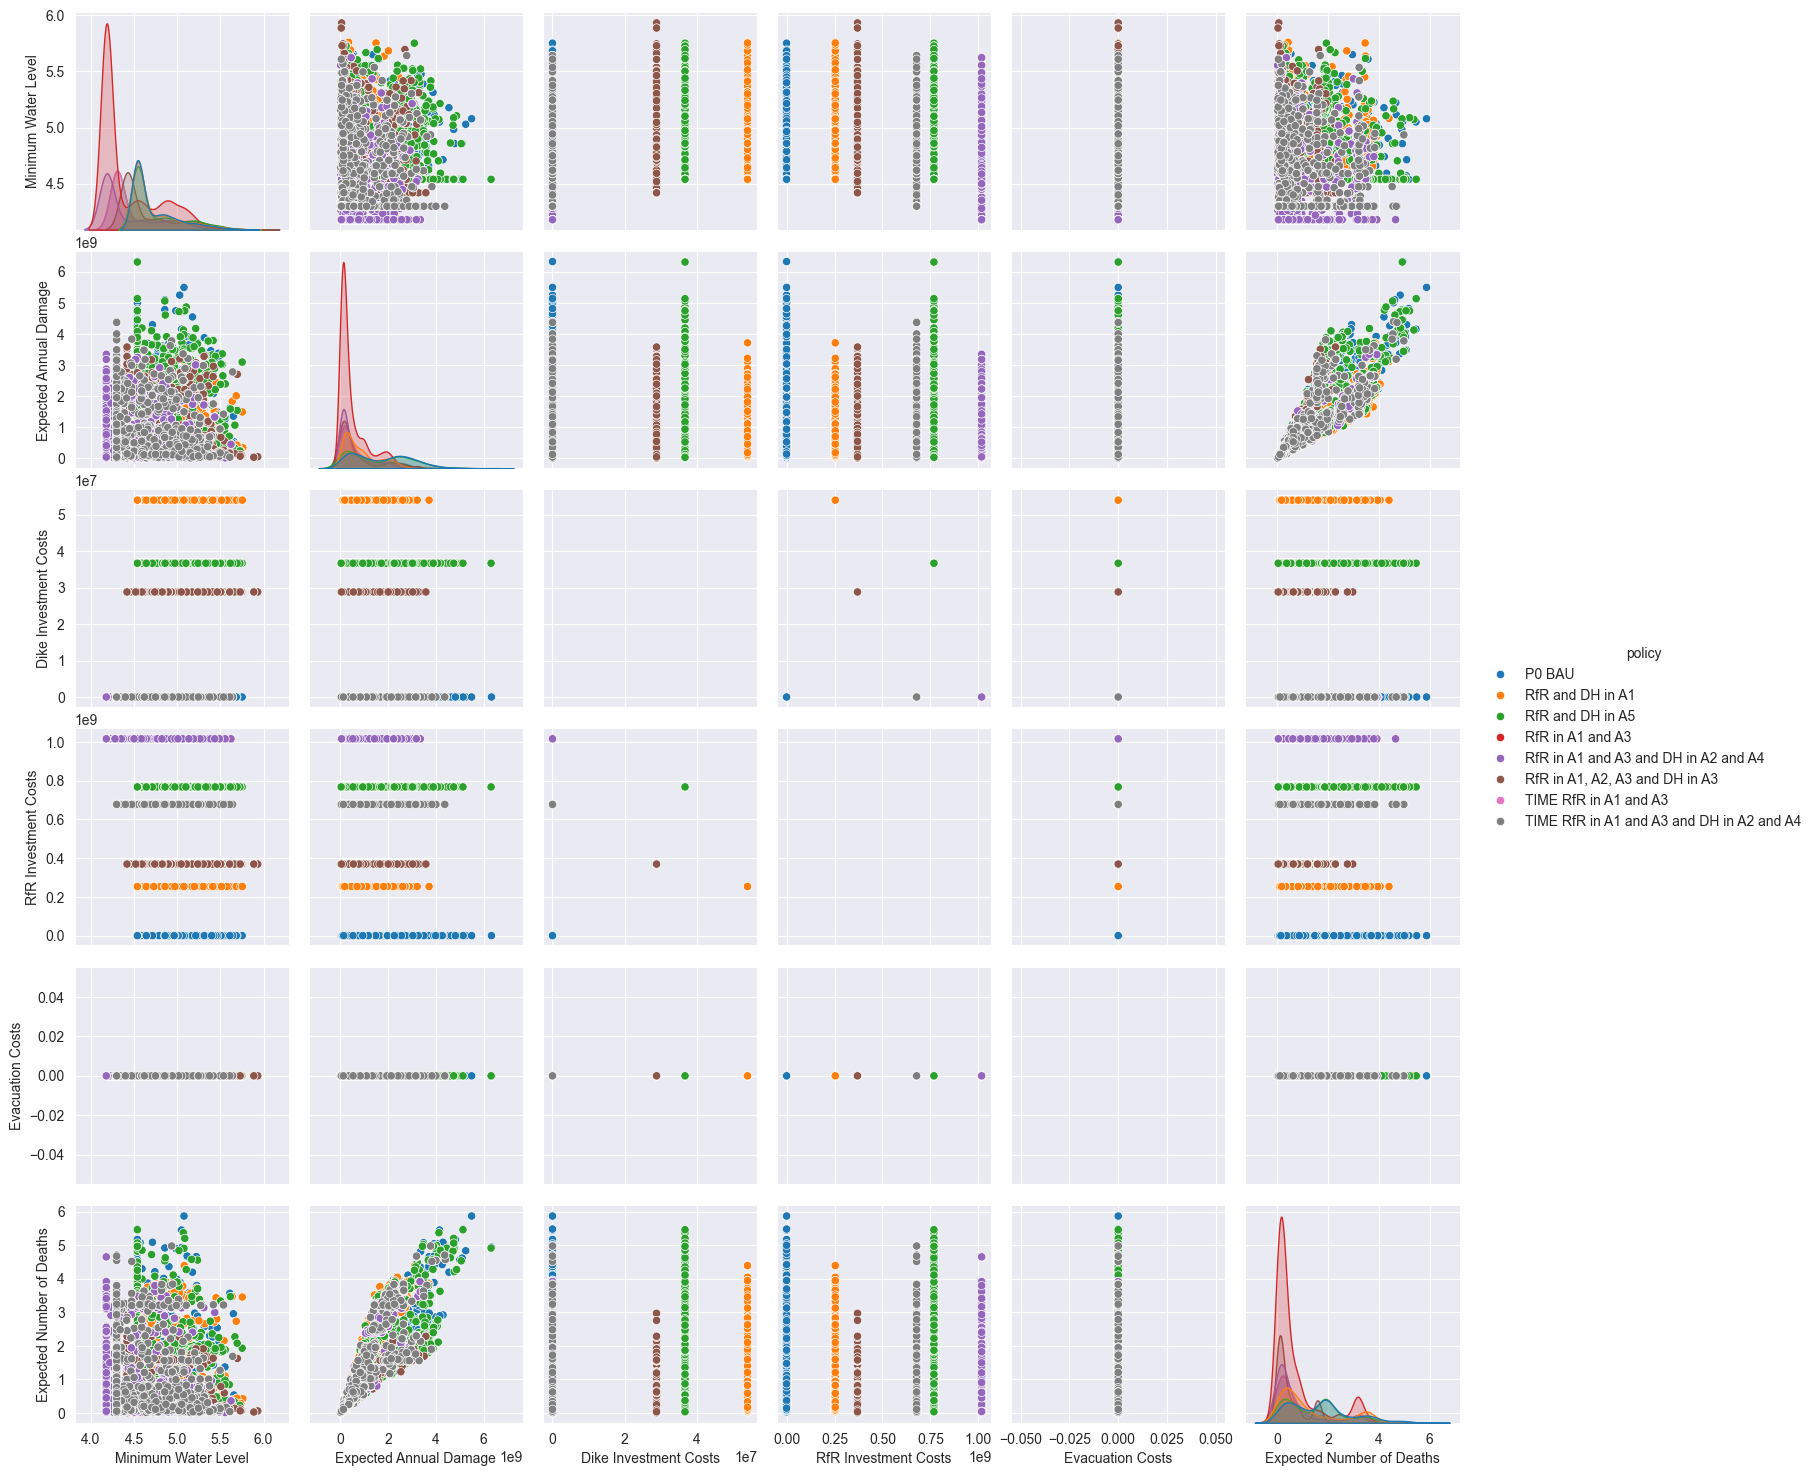

In [157]:
policies_open_exp_2 = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_open_exp_2

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig("Open exploration policies's outcome vs outcome BAU")

In [158]:
experiments.dtypes

A.0_ID flood wave shape       int64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                       int64
0_RfR 1                       int64
0_RfR 2                       int64
1_RfR 0                       int64
1_RfR 1                       int64
1_RfR 2                       int64
2_RfR 0                       int64
2_RfR 1                       int64
2_RfR 2                     

In [159]:
#RfR should be 0 or 1, so we can convert it to boolean
for col in experiments.columns:
    if 'RfR' in col:
        experiments[col] = experiments[col].astype(bool)

# Dike heightening should float
for col in experiments.columns:
    if 'DikeIncrease' in col:
        experiments[col] = experiments[col].astype(float)

experiments.dtypes

A.0_ID flood wave shape       int64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                        bool
0_RfR 1                        bool
0_RfR 2                        bool
1_RfR 0                        bool
1_RfR 1                        bool
1_RfR 2                        bool
2_RfR 0                        bool
2_RfR 1                        bool
2_RfR 2                     

In [160]:
outcomes_df = pd.DataFrame(outcomes)

experiments_df = pd.DataFrame(experiments)

cleaned_experiments = experiments_df.drop(labels=[l.name for l in dike_model.levers], axis=1)

## 2. PRIM - Amaryllis

In [212]:
import pickle
with open('./data/sobol_results.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Divides the loaded data into experiment and outcome data
x =loaded_data[0]
df =pd.DataFrame(loaded_data[1])

In [214]:
#PRIM REFERENCE SCENARIO

target = (
    (df['Minimum Water Level'] < 5) )

print(target.sum())        # Total number of True values
print(len(target))         # Total number of cases
print(np.unique(target))   # Should be [True, False]


32614
40000
[False  True]


[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 40000 points remaining, containing 32614 cases of interest
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc

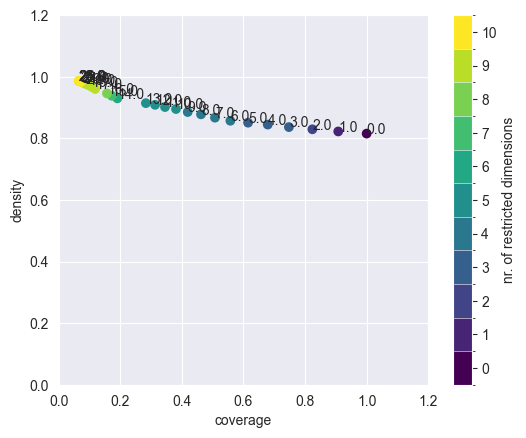

In [215]:
# take x from SOBOL (make sure only uncertainties, not policies) x is only first column?
prim_alg = prim.Prim(x, target, threshold=0.8, peel_alpha=0.1)
box_experiments = prim_alg.find_box()

box_experiments.show_tradeoff(annotated=True)
plt.show()

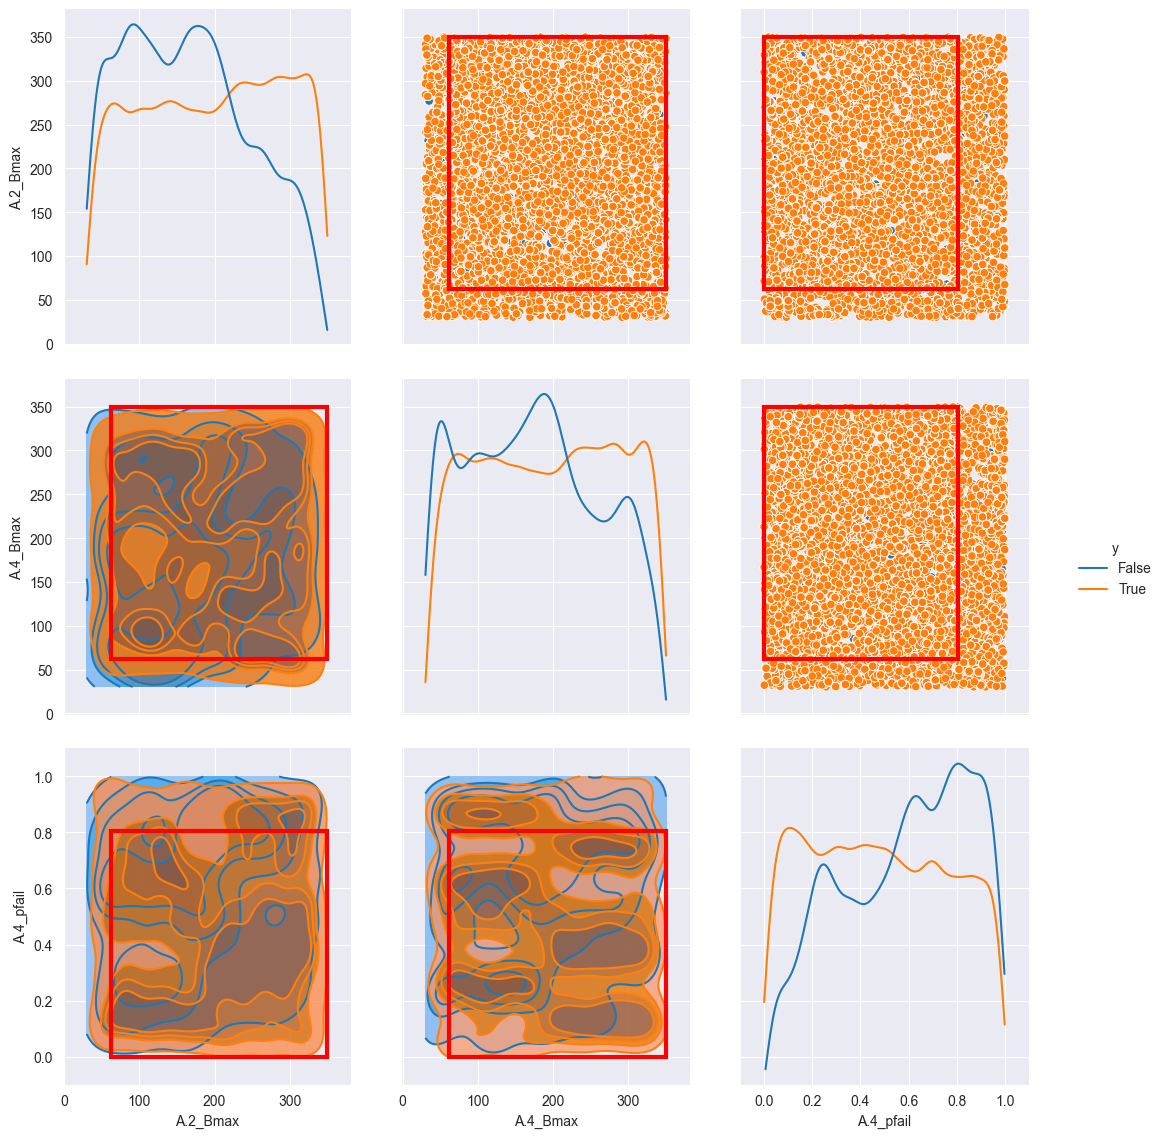

In [217]:
# Show the distribution between samples and the prim boundaries
box_experiments.select(4)
box_experiments.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.show()


coverage        0.678880
density         0.844625
id              4.000000
k           22141.000000
mass            0.655350
mean            0.844625
n           26214.000000
res_dim         3.000000
Name: 4, dtype: float64

               box 4                                    
                 min         max  qp value      qp value
A.4_pfail   0.000350    0.805512       NaN  2.353262e-13
A.4_Bmax   61.613696  349.887300  0.000021           NaN
A.2_Bmax   62.764273  349.814707  0.000081           NaN



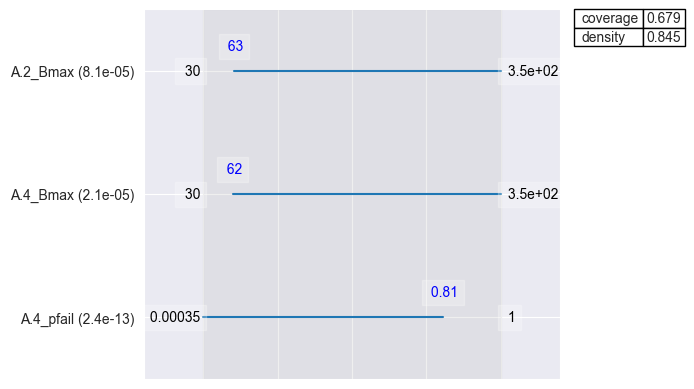

In [218]:
# Show prim statistics
box_experiments.inspect(4)

# Plot boundaries prim in graph
box_experiments.inspect(4, style="graph")
plt.show()

In [220]:
# Saves the boundary data of prim
pd.DataFrame(box_experiments.inspect(4, style='data')[0][1]).to_csv('./data/para_space_all.csv')

In [239]:
import pandas as pd
import pickle
from ema_workbench import Scenario
from problem_formulation import get_model_for_problem_formulation  # Ensure this exists

# Load the PRIM box boundaries
df_param_space_all = (
    pd.read_csv('./data/para_space_all.csv')
    .drop(0)  # Drops the duplicated header row
    .rename(columns={"Unnamed: 0": "Variable"})
)

# Get the model and uncertainties
dike_model, planning_steps = get_model_for_problem_formulation(2)

def create_scenario_from_box():
    """Creates a Scenario using the midpoint values from the PRIM box boundaries."""
    para_list = []

    for uncertainty in dike_model.uncertainties:
        variable = uncertainty.name

        if variable in df_param_space_all.Variable.values:
            min_val = float(df_param_space_all[df_param_space_all['Variable'] == variable].iloc[0, 1])
            max_val = float(df_param_space_all[df_param_space_all['Variable'] == variable].iloc[0, 2])
            para_list.append((min_val + max_val) / 2)
        elif variable.startswith("d"):  # Discount rate
            para_list.append(3.5)
        elif variable == "A.0_ID flood wave shape":
            para_list.append(17)
        elif variable.endswith("Brate"):
            para_list.append(1.5)
        else:
            # Default: midpoint of the full uncertainty range
            para_list.append(
                uncertainty.lower_bound + (uncertainty.upper_bound - uncertainty.lower_bound) / 2
            )

    # Debug print: Check the lists before zipping
    print("Uncertainty names:", [u.name for u in dike_model.uncertainties])
    print("Parameter values:", para_list)

    # Create a dict of {uncertainty name: value}
    scenario_data = dict(zip([u.name for u in dike_model.uncertainties], para_list))

    # Debug print: Check the final scenario_data dict
    print("Scenario data:", scenario_data)

    # Create a Scenario with that dict and a name (use ** to unpack the dictionary into keyword arguments)
    return Scenario("PRIM_Midpoint", **scenario_data)

# Create the scenario
reference_scenario = [create_scenario_from_box()]

# Save to .pkl
with open("./data/reference_scenario", "wb") as file:
    pickle.dump(reference_scenario, file)




Uncertainty names: ['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']
Parameter values: [3.5, 3.5, 3.5, 17, 190.0, 0.5, 1.5, 206.28949001431465, 0.5, 1.5, 190.0, 0.5, 1.5, 205.750497803092, 0.40293108276091516, 1.5, 190.0, 0.5, 1.5]
Scenario data: {'discount rate 0': 3.5, 'discount rate 1': 3.5, 'discount rate 2': 3.5, 'A.0_ID flood wave shape': 17, 'A.1_Bmax': 190.0, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5, 'A.2_Bmax': 206.28949001431465, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5, 'A.3_Bmax': 190.0, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5, 'A.4_Bmax': 205.750497803092, 'A.4_pfail': 0.40293108276091516, 'A.4_Brate': 1.5, 'A.5_Bmax': 190.0, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5}


In [240]:
# Save as CSV to check
# Convert the scenario data to a DataFrame
scenario_df = pd.DataFrame([reference_scenario])

# Save to CSV
scenario_df.to_csv("./data/reference_scenario.csv", index=False)


### Random policies against MWL

In [161]:
# === Define target for PRIM ===
target = (
    (random_outcomes['Minimum Water Level'] < 4.5) )

In [162]:
# === Run PRIM without cleaning the experiments===
prim_alg = prim.Prim(random_experiments_df, target, threshold=0.8, peel_alpha=0.1)
box_raw_experiments = prim_alg.find_box()

# here model gets removed, but shouldn't policy and scenario also get removed?

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 5028 cases of interest
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '126.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/pyt

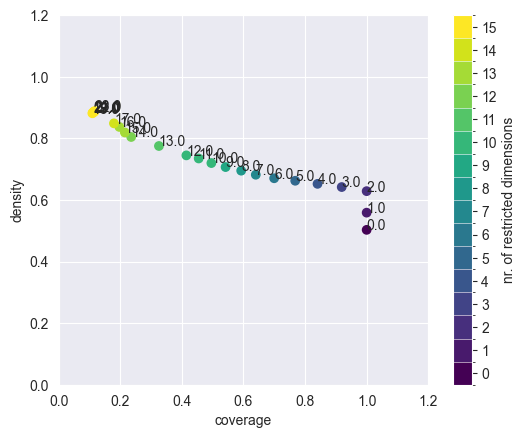

In [163]:
box_raw_experiments.show_tradeoff(annotated=True)
plt.show()

In [164]:
#With cleaned experiments
prim_alg = prim.Prim(random_cleaned_experiments, target, threshold=0.75)

box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 5028 cases of interest
[MainProcess/INFO] mean: 0.8492647058823529, mass: 0.1088, coverage: 0.18377088305489261, density: 0.8492647058823529 restricted_dimensions: 12


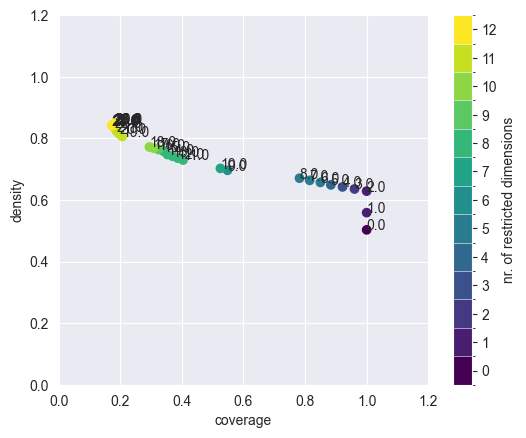

In [165]:
box1.show_tradeoff(annotated =True)
plt.show()

### Random policies against MWL + other stakeholder interests

In [166]:
import numpy as np

# Define the percentile threshold (e.g., 80th percentile = worst 20%)
percentile = 0.8
n = len(outcomes)

# Compute the cutoff values for each variable
death_cutoff = np.sort(random_outcomes['Expected Number of Deaths'])[int(percentile * n)]
damage_cutoff = np.sort(random_outcomes['Expected Annual Damage'])[int(percentile * n)]
evac_cost_cutoff = np.sort(random_outcomes['Evacuation Costs'])[int(percentile * n)]
rfr_cost_cutoff = np.sort(random_outcomes['RfR Investment Costs'])[int(percentile * n)]
dike_cost_cutoff = np.sort(random_outcomes['Dike Investment Costs'])[int(percentile * n)]

# Combine into a single boolean target for PRIM
target = (
    (random_outcomes['Minimum Water Level'] < 4.5) &
    (
        (random_outcomes['Expected Number of Deaths'] > death_cutoff) |
        (random_outcomes['Expected Annual Damage'] > damage_cutoff) |
        (random_outcomes['Evacuation Costs'] > evac_cost_cutoff) |
        (random_outcomes['RfR Investment Costs'] > rfr_cost_cutoff) |
        (random_outcomes['Dike Investment Costs'] > dike_cost_cutoff)
    )
)

#focussing on scenarios where the water level is too low and at least one other variable is bad

In [167]:
print(target.sum())        # Total number of True values
print(len(target))         # Total number of cases
print(np.unique(target))   # Should be [True, False]

5028
10000
[False  True]


In [168]:
# === Run PRIM without cleaning the experiments===
prim_alg = prim.Prim(random_experiments_df, target, threshold=0.8, peel_alpha=0.1)
box_raw_experiments = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 5028 cases of interest
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '126.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/pyt

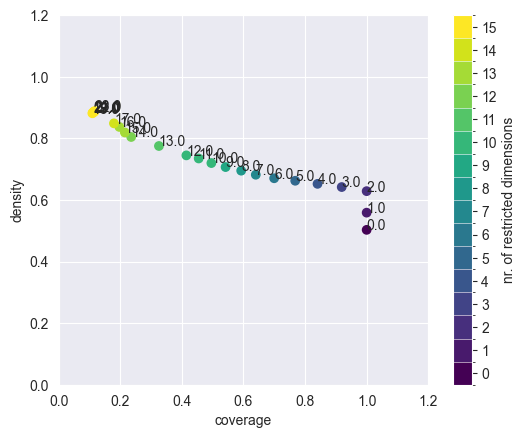

In [169]:
box_raw_experiments.show_tradeoff(annotated=True)
plt.show()

In [170]:
#With cleaned experiments
prim_alg = prim.Prim(random_cleaned_experiments, target, threshold=0.75)

box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 5028 cases of interest
[MainProcess/INFO] mean: 0.8492647058823529, mass: 0.1088, coverage: 0.18377088305489261, density: 0.8492647058823529 restricted_dimensions: 12


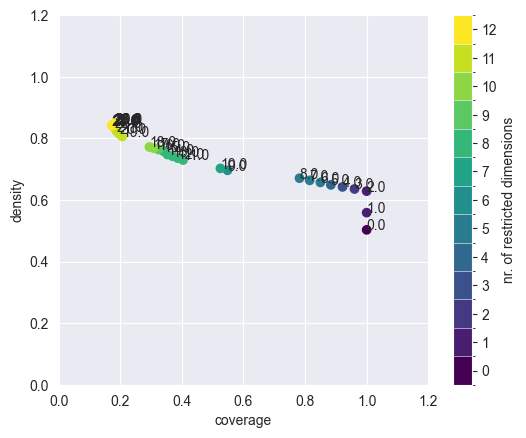

In [171]:
box1.show_tradeoff(annotated =True)
plt.show()

### Selected policies against MWL

In [190]:
# Print all available outcome names
print("Available outcome names:")
for outcome_name in outcomes.keys():
    print(outcome_name)

Available outcome names:
Minimum Water Level
Expected Annual Damage
Dike Investment Costs
RfR Investment Costs
Evacuation Costs
Expected Number of Deaths


In the first iteration we will focus on minimum water level exclusively to identify worst case scenarios

In [191]:
# === Define target for PRIM ===
target = (
    (outcomes['Minimum Water Level'] < 4.5) )

In [192]:
print(target.sum())        # Total number of True values
print(len(target))         # Total number of cases
print(np.unique(target))   # Should be [True, False]

4649
10000
[False  True]


In [193]:
# === Run PRIM without cleaning the experiments===
prim_alg = prim.Prim(experiments_df, target, threshold=0.8, peel_alpha=0.1)
box_raw_experiments = prim_alg.find_box()

#2_RfR has never been used, so that is alright

[MainProcess/INFO] column 2_RfR 0 dropped from analysis because it has only one category
[MainProcess/INFO] column 2_RfR 2 dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 4649 cases of interest
[MainProcess/INFO] mean: 0.9296296296296296, mass: 0.054, coverage: 0.10798021079802107, density: 0.9296296296296296 restricted_dimensions: 12


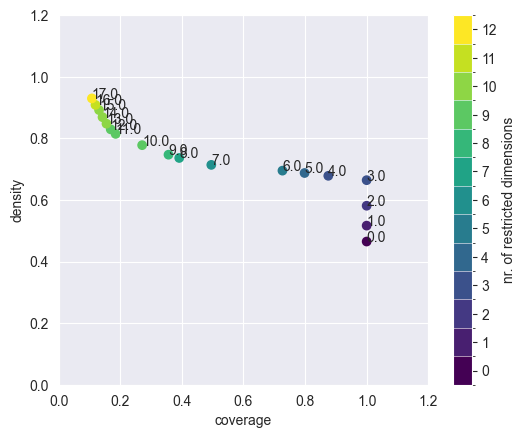

In [194]:
box_raw_experiments.show_tradeoff(annotated=True)
plt.show()

Why do the gaps appear?

The gaps between points mean that:

PRIM couldn't find useful restrictions for several steps (e.g., tried peeling, but the gain was too small).
There’s a discrete jump in performance because the search algorithm only accepts a new box if the improvement passes a threshold.
The step between two boxes significantly changed the restricted dimensions, resulting in a sudden change in coverage or density.
This is especially common when:

Some dimensions are flat (don’t vary much or don't correlate with the target).
The target is sparse or not easily separable.
The peeling step (peel_alpha) is relatively large, skipping over small improvements.

In [195]:
from ema_workbench.analysis import prim
#With cleaned experiments


prim_alg = prim.Prim(cleaned_experiments, target, threshold=0.8, peel_alpha=0.1)


box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 4649 cases of interest
[MainProcess/INFO] mean: 0.9296296296296296, mass: 0.054, coverage: 0.10798021079802107, density: 0.9296296296296296 restricted_dimensions: 10


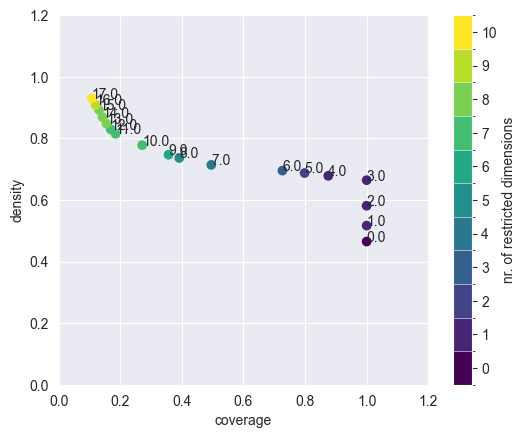

In [196]:
box1.show_tradeoff(annotated =True)
plt.show()

Choose a box that has moderate to high coverage (which means it captures many of the good cases, in this case of the worst-case scenario)
And high density


coverage       0.726608
density        0.695062
id             6.000000
k           3378.000000
mass           0.486000
mean           0.695062
n           4860.000000
res_dim        5.000000
Name: 6, dtype: float64

                                                                box 6  \
                                                                  min   
A.1_DikeIncrease 0                                                0.0   
A.5_DikeIncrease 0                                                0.0   
A.3_pfail                                                    0.000824   
A.1_pfail                                                    0.000439   
policy              {TIME RfR in A1 and A3, RfR in A1 and A3 and D...   

                                                                       \
                                                                  max   
A.1_DikeIncrease 0                                                2.5   
A.5_DikeIncrease 0                                  

/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{'TIME RfR in A1 and A3', 'RfR in A1 and A3 and DH in A2 and A4', 'RfR and DH in A1', 'RfR and DH in A5', 'RfR in A1 and A3', 'TIME RfR in A1 and A3 and DH in A2 and A4'}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{'TIME RfR in A1 and A3', 'RfR in A1 and A3 and DH in A2 and A4', 'RfR and DH in A1', 'RfR and DH in A5', 'RfR in A1 and A3', 'TIME RfR in A1 and A3 and DH in A2 and A4'}

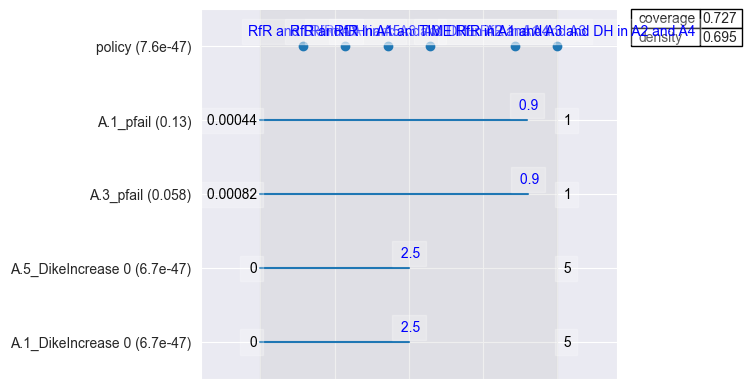

In [198]:
point = 6

#inspect this box
box_raw_experiments.inspect(point)
box_raw_experiments.inspect(point, style = 'graph')
plt.show()

Here explain the outcomes of the box:
This shows that policy 3, 4 and 5 are bad outcomes for the transport company as the water-level drops below 4.5m. Policy 4 and 5 were considered in the first debate, so this is something the transport company needs to avoid.

Now, we resample to check the robustness of the box. This is done by applying the box's contraints to resampled or shuffled versions of the data. Hereby we can see how much the box's performance was due to overfitting. If the resampled box still shows high coverage and density, the pattern is likely real and stable

In [199]:
box1.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: S

,reproduce coverage,reproduce density
policy,100.0,100.0
A.3_pfail,80.0,80.0
A.1_pfail,40.0,40.0
A.1_Brate,10.0,10.0
A.4_Brate,10.0,10.0
A.5_Bmax,10.0,10.0
A.5_pfail,10.0,10.0
A.4_Bmax,10.0,0.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0


What the results of the resampling tells us is that the Policy variable is very robust. This constraint is always part of high-performing boxes in resampled data. This confirms the highly significant quasi p-values in the previous figure. Rest is not robust I think, so the other variables can be safely ignored when interpreting the results.

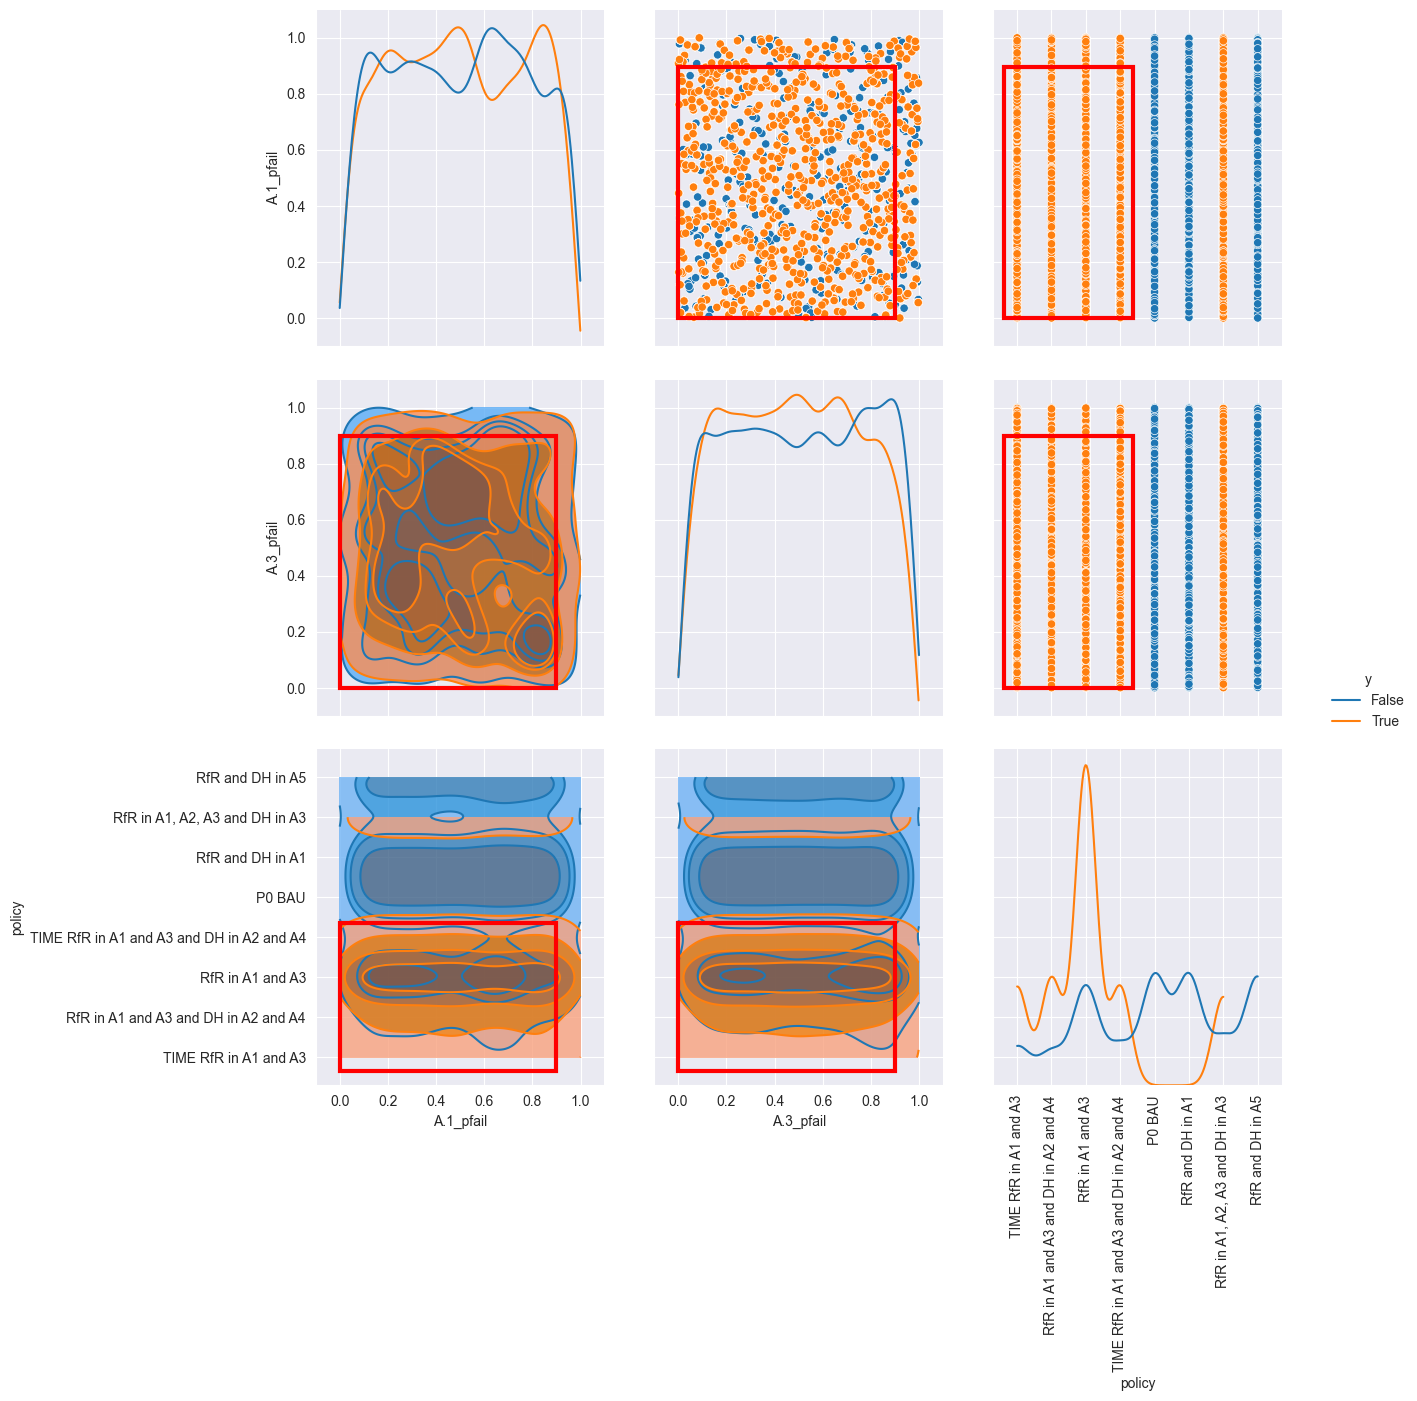

In [200]:
box1.select(point)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

The pair-wise scatterplot shows in orange the cases of interest and in blue the cases of not interest. The red square indicates the identified box limits for each pair of parameters.

In the next step, the results are visualized using dimensional stacking.

[MainProcess/INFO] model dropped from analysis because only a single category
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


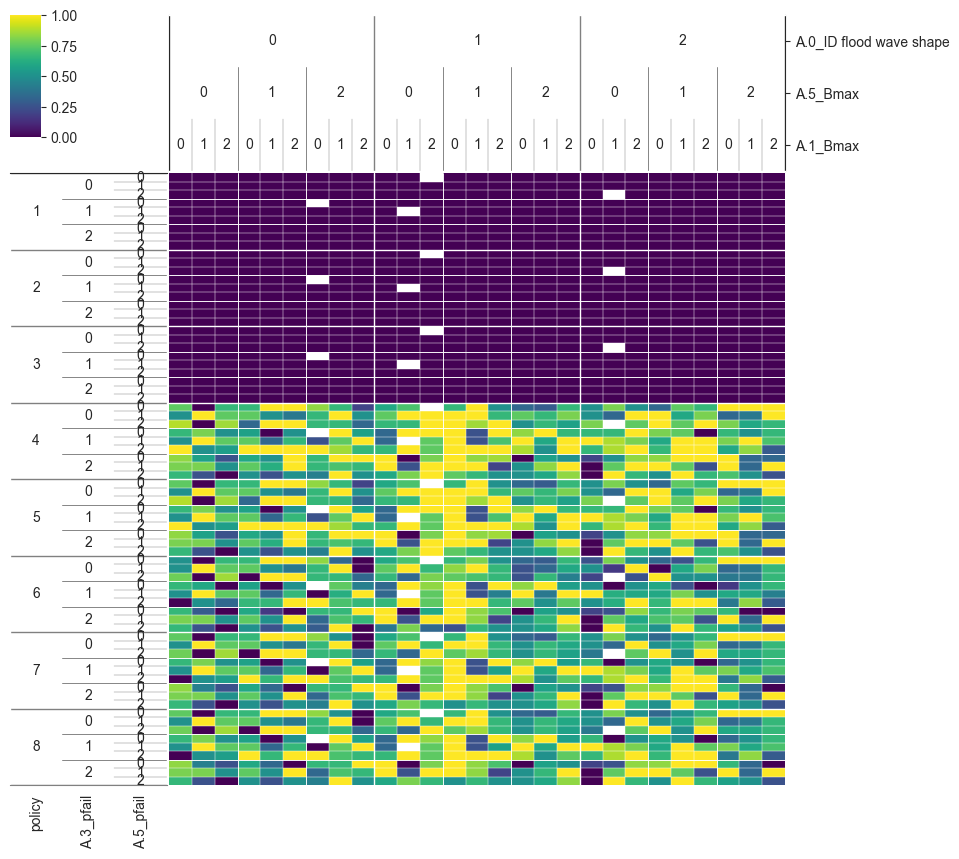

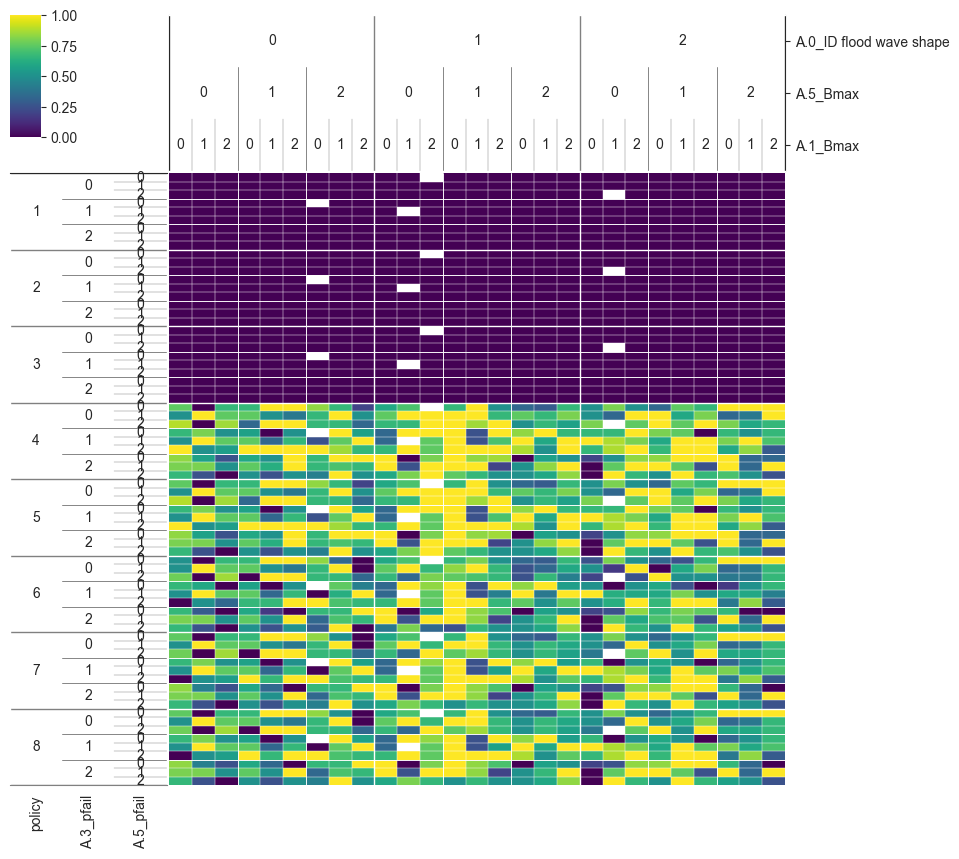

In [201]:
from ema_workbench.analysis import dimensional_stacking
dimensional_stacking.create_pivot_plot(cleaned_experiments, target)

### Selected policies against MWL + other stakeholders'interests

In [202]:
import numpy as np

# Define the percentile threshold (e.g., 80th percentile = worst 20%)
percentile = 0.8
n = len(outcomes)

# Compute the cutoff values for each variable
death_cutoff = np.sort(outcomes['Expected Number of Deaths'])[int(percentile * n)]
damage_cutoff = np.sort(outcomes['Expected Annual Damage'])[int(percentile * n)]
evac_cost_cutoff = np.sort(outcomes['Evacuation Costs'])[int(percentile * n)]
rfr_cost_cutoff = np.sort(outcomes['RfR Investment Costs'])[int(percentile * n)]
dike_cost_cutoff = np.sort(outcomes['Dike Investment Costs'])[int(percentile * n)]

# Combine into a single boolean target for PRIM
target = (
        (outcomes['Minimum Water Level'] < 4.5) &
        (
                (outcomes['Expected Number of Deaths'] > death_cutoff) |
                (outcomes['Expected Annual Damage'] > damage_cutoff) |
                (outcomes['Evacuation Costs'] > evac_cost_cutoff) |
                (outcomes['RfR Investment Costs'] > rfr_cost_cutoff) |
                (outcomes['Dike Investment Costs'] > dike_cost_cutoff)
        )
)

#focussing on scenarios where the water level is too low and at least one other variable is bad

In [203]:
print(target.sum())  # Total number of True values
print(len(target))  # Total number of cases
print(np.unique(target))  # Should be [True, False]

4649
10000
[False  True]


[MainProcess/INFO] column 2_RfR 0 dropped from analysis because it has only one category
[MainProcess/INFO] column 2_RfR 2 dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 4649 cases of interest
[MainProcess/INFO] mean: 0.9296296296296296, mass: 0.054, coverage: 0.10798021079802107, density: 0.9296296296296296 restricted_dimensions: 12


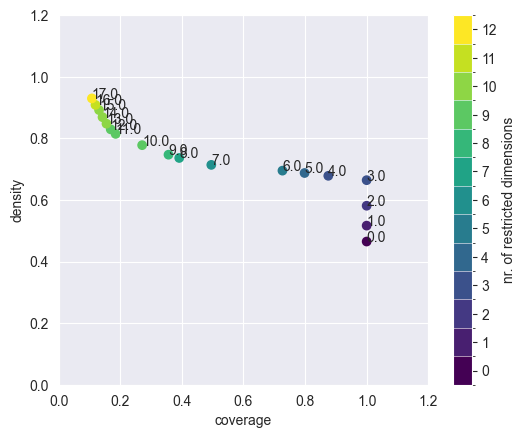

In [204]:
# === Run PRIM without cleaning the experiments===
prim_alg = prim.Prim(experiments_df, target, threshold=0.8, peel_alpha=0.1)
box_raw_experiments = prim_alg.find_box()
box_raw_experiments.show_tradeoff(annotated=True)
plt.show()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 4649 cases of interest
[MainProcess/INFO] mean: 0.8907563025210085, mass: 0.0714, coverage: 0.13680361368036137, density: 0.8907563025210085 restricted_dimensions: 12


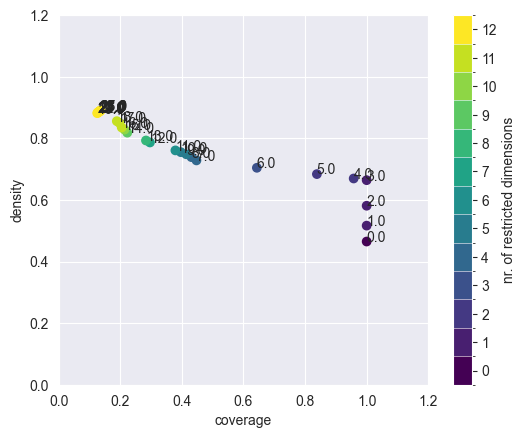

In [205]:
#With cleaned experiments
prim_alg = prim.Prim(cleaned_experiments, target, threshold=0.75)

box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

# Other stuff/ questions

- What should we do with the results of BAU?
- Difference between cleaned experiments and experiments in PRIM?
-               We want to explore combinations of uncertainty and policy settings, so they we shouldn't use the clean one. With the clean one, you are only exploring uncertainties (not policies)
-               With the clean_experiments we are also getting the weird jumps
- Why does PRIM make such big jumps? Something with peel_alpha?
- 2_RfR is removed by PRIM as it does not change, what does this mean?


Later: 
- Interpret all graphs together
- choose prim box
- Write our pretty report